In [90]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.autograd import Variable
from IPython.core.debugger import set_trace
from PIL import Image

In [150]:
from Trainer import Trainer
from Tools import Dataloader

In [92]:
torch.manual_seed(0);

In [94]:
normalize = torchvision.transforms.Normalize((0.4895832, 0.4546405, 0.41594946), 
                                 (0.2520022, 0.24522494, 0.24728711))
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               normalize])

# transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

data = torchvision.datasets.ImageFolder(
                    root='./data/trainset/',
                    transform=transforms
                    )

test_data = torchvision.datasets.ImageFolder(
                    root= './data/test/', 
                    transform=transforms)

dataset_ratio = np.array([95, 5])/100

sizes = [int(x*len(data)) for x in dataset_ratio]
sizes[0] += len(data) - sum(sizes)

train_dataset, valid_dataset = torch.utils.data.random_split(dataset=data, lengths=sizes)
train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=128,
                    num_workers=2,
                    shuffle=True
                    )

valid_loader = torch.utils.data.DataLoader(
                    valid_dataset,
                    batch_size=128,
                    num_workers=2,
                    shuffle=True
                    )

test_loader = torch.utils.data.DataLoader(test_data,
                                         batch_size=128,
                                        num_workers=1)
classes = ('Cat', 'Dog')

In [34]:
def flaotTensorToImage(img, mean=0, std=1):
    """convert a tensor to an image"""
    img = np.transpose(img.numpy(), (1, 2, 0))
    img = (img*std+ mean)*255
    img = img.astype(np.uint8)    
    return img  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Batch shape: (128, 3, 64, 64)
(64, 64, 3)


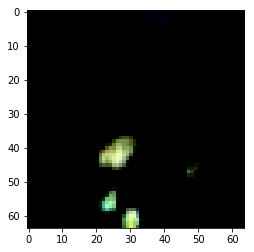

In [36]:
imgs, steering_angle = next(iter(test_loader))
print (steering_angle)
print('Batch shape:',imgs.numpy().shape)
im = imgs[0].numpy()
im2display = im.transpose((1,2,0))
print(im2display.shape)
plt.imshow(im2display, interpolation='nearest')
plt.show()
# plt.imshow(imgs.numpy()[0,:,:,:])
# plt.show()
# plt.imshow(imgs.numpy()[-1,:,:,:])
# plt.show()

In [7]:
## get the mean and variance of our dataset for normalization

train = train_loader.__iter__().next()[0]
print (len(train_loader.dataset))
print('Mean: {}'.format(np.mean(train.numpy(), axis=(0, 2, 3))))
print('STD: {}'.format(np.std(train.numpy(), axis=(0, 2, 3))))

18999
Mean: [0.00149352 0.01866901 0.0075541 ]
STD: [0.9907048  0.99137974 1.0037811 ]


In [8]:
cuda_available = torch.cuda.is_available()
print(cuda_available)

True


In [9]:
# learning_rate = 1e-3

optim = 'sgd'
num_epochs = 100
best_acc = torch.FloatTensor([0])
start_epoch = 0

In [10]:
def dropout(p=None, dim=None, method='standard'):
    if method == 'standard':
        return nn.Dropout(p)
    elif method == 'gaussian':
        return GaussianDropout(p/(1-p))
    elif method == 'variational':
        return VariationalDropout(p/(1-p), dim)

In [11]:
class GaussianDropout(nn.Module):
    def __init__(self, alpha=1.0):
        super(GaussianDropout, self).__init__()
        self.alpha = torch.Tensor([alpha])
        
    def forward(self, x):
        """
        Sample noise   e ~ N(1, alpha)
        Multiply noise h = h_ * e
        """
        if self.train():
            # N(1, alpha)
            epsilon = torch.randn(x.size()) * self.alpha + 1

            epsilon = Variable(epsilon)
            if x.is_cuda:
                epsilon = epsilon.cuda()

            return x * epsilon
        else:
            return x

In [12]:
class XavierClassifier(nn.Module):
    def __init__(self):
        super(XavierClassifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=3, out_channels=16,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            dropout(0.5, 16,'gaussian'),
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=128,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # Layer 6
            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
             # Layer 7
            nn.Conv2d(in_channels=256, out_channels=256,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # Layer 8
            nn.Conv2d(in_channels=256, out_channels=512,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            # Layer 9
            nn.Conv2d(in_channels=512, out_channels=512,kernel_size=(3,3) , padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            dropout(0.5, 512,'gaussian'),
            
        )
        self.net = nn.Linear(512, 512)
        self.net = nn.Linear(512, 2)
        self.init_weights()
    def forward(self, x):
        return self.net(self.conv(x).squeeze())
    
    def init_weights(self):
        for m in self.conv:
            if isinstance(m,nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        if type(self.net) == nn.Linear:
            nn.init.xavier_uniform_(self.net.weight)
            self.net.bias.data.fill_(0.01)

In [13]:
classifiers = ['ResidualClassifier', "VanilaCNN", "XavierClassifier" ]
my_classifier = 'XavierClassifier'

if my_classifier=='ResidualClassifier':
    model = ResidualClassifier()
elif my_classifier=='VanilaCNN':
    model = VanilaCNN() 
elif my_classifier=='XavierClassifier':
    model = XavierClassifier() 
    
learning_rate = 0.1

if cuda_available:
    model = model.cuda()
if optim == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#     optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.95)
elif optim == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [14]:
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
              ReLU-2           [-1, 16, 64, 64]               0
   GaussianDropout-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           4,640
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
             ReLU-10          [-1, 128, 32, 32]               0
        MaxPool2d-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [138]:
hyperparams = {'num_epochs': 10,
               'lr0' :0.1, 
               'save_checkpoint': False
                  }

In [139]:
trainer = Trainer(model, optimizer, criterion, train_loader, valid_loader, test_loader, hyperparams)
nll_train, nll_test, acc_train, acc_test =  trainer.train_model()
print('Done...')

------ Epoch # 1 ------
 Iteration 40: TRAIN 0.5883
 Iteration 80: TRAIN 0.5850
 Iteration 120: TRAIN 0.5865
------ Epoch # 2 ------
 Iteration 160: TRAIN 0.5739
 Iteration 200: TRAIN 0.5621
 [Loss] TRAIN 0.5395 / VALID 0.5712
 [ACC] TRAIN 0.7331 / VALID 0.6987
 Iteration 240: TRAIN 0.5657
 Iteration 280: TRAIN 0.5629
------ Epoch # 3 ------
 Iteration 320: TRAIN 0.5470
 Iteration 360: TRAIN 0.5448
 Iteration 400: TRAIN 0.5383
 [Loss] TRAIN 0.5496 / VALID 0.5848
 [ACC] TRAIN 0.7230 / VALID 0.7087
 Iteration 440: TRAIN 0.5272
------ Epoch # 4 ------
 Iteration 480: TRAIN 0.5237
 Iteration 520: TRAIN 0.4994
 Iteration 560: TRAIN 0.5121
------ Epoch # 5 ------
 Iteration 600: TRAIN 0.5062
 [Loss] TRAIN 0.4692 / VALID 0.5138
 [ACC] TRAIN 0.7813 / VALID 0.7548
 Iteration 640: TRAIN 0.4822
 Iteration 680: TRAIN 0.4864
 Iteration 720: TRAIN 0.4742
------ Epoch # 6 ------
 Iteration 760: TRAIN 0.4738
 Iteration 800: TRAIN 0.4653
 [Loss] TRAIN 0.5010 / VALID 0.6013
 [ACC] TRAIN 0.7458 / VALID 0

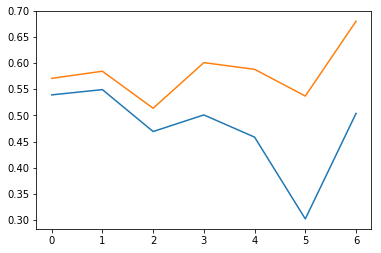

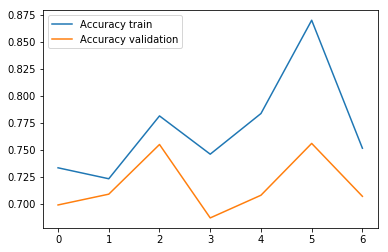

In [140]:
plt.figure(1)
plt.plot(range(len(nll_train)), nll_train, label="Loss train" )
plt.plot(range(len(nll_test)), nll_test,   label="Loss validation" )
plt.figure(2)
plt.plot(range(len(acc_train)), acc_train, label="Accuracy train" )
plt.plot(range(len(acc_test)), acc_test,   label="Accuracy validation" )
plt.legend()
plt.show()

In [141]:
# from PIL import Image
# files = []
# tensor = torchvision.transforms.ToTensor()
# imgs = torch.Tensor()
# for i in range(1,4999+1):
#     address = "./data/test/" + (str(i)+".jpg")
#     img = Image.open(address)
#     img_ = tensor(img)
#     imgs.

In [142]:
# results = [[]]
# for batch_idx, (inputs, targets) in enumerate(test_loader):
#     if cuda_available:
#         inputs, targets = inputs.cuda(), targets.cuda()
#     outputs = model(inputs)
#     _, predicted = torch.max(outputs.data, 1)
#     results = np.append(results, predicted.cpu().numpy())

# results = np.int8(results)

In [106]:
df = pd.DataFrame({ 'id': range(1, len(results)+1),
                    'label': results})
df['label'].replace([0,1], ['Cat','Dog'], inplace=True)
df[df.columns].to_csv('submisstion.csv',index=False)
print('Done...')

Done...


In [143]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()

class DriveData(Dataset):
    __xs = []
    __ys = []

    def __init__(self, folder_dataset, transform=None):
        self.transform = transform
        # Open and load text file including the whole training data
        
        for i in range(1,5000):
            address = folder_dataset + (str(i)+".jpg")
            self.__xs.append(address)

    # Override to give PyTorch access to any image on the dataset
    def __getitem__(self, index):
        img = Image.open(self.__xs[index])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        # Convert image and label to torch tensors
        img = np.transpose(np.asarray(img), (2, 0, 1))
        img = torch.from_numpy(np.asarray(img))
        
        return img, 0

    # Override to give PyTorch size of dataset
    def __len__(self):
        return len(self.__xs)

In [161]:
# dset_train = DriveData("./data/test/`/")
# test_loader2 = DataLoader(dset_train, batch_size=10, shuffle=False, num_workers=1)

In [162]:
imgs, steering_angle = next(iter(test_loader2))
print (steering_angle)
print('Batch shape:',imgs.numpy().shape)
im = imgs[6].numpy()
im2display = im.transpose((1,2,0))
print(im2display.shape)
plt.imshow(im2display, interpolation='nearest')
plt.show()

FileNotFoundError: Traceback (most recent call last):
  File "/home/mehrzaed/Software/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/mehrzaed/Software/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "<ipython-input-143-77f51782fdf7>", line 24, in __getitem__
    img = Image.open(self.__xs[index])
  File "/home/mehrzaed/Software/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 2609, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: './data/test/test/1.jpg'


In [ ]:
results = [[]]
for batch_idx, (inputs, targets) in enumerate(test_loader2):
    if cuda_available:
        inputs, targets = inputs.cuda(), targets.cuda()
    inputs= inputs.type(torch.cuda.FloatTensor)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    results = np.append(results, predicted.cpu().numpy())

results = np.int8(results)

In [147]:
print(len(results))

4999


In [148]:
df = pd.DataFrame({ 'id': range(1, len(results)+1),
                    'label': results})
df['label'].replace([0,1], ['Cat','Dog'], inplace=True)
df[df.columns].to_csv('submisstion.csv',index=False)
print('Done...')

Done...
